In [1]:
import sys
import skvideo.io
import skvideo.datasets

/home/misha/tensorflow/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D

Using TensorFlow backend.


In [3]:
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils

In [4]:
import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing

/home/misha/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


### Image specification

In [6]:
img_rows,img_cols,img_depth=200,300,15

### Training data

In [7]:
X_tr = [] # variable to store entire dataset

### Open files

In [8]:
# load class 0
filename = '/home/misha/Documents/Thesis/Dataset/BNG_white_1'
videodata = skvideo.io.vreader(filename + '.mov')
frames = open(filename + '.csv', 'r')

my_frame = 0
frame_number = 0

for frame in videodata:
    if (frame_number >= 10 and frame_number < 510):
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res_img = cv2.resize(frame, (img_cols, img_rows), interpolation=cv2.INTER_AREA)
        X_tr.append(res_img)
#         print(frame_number)
    frame_number += 1
print('Class 0:', len(X_tr))



# load class 1
filename = '/home/misha/Documents/Thesis/Dataset/race_night'
videodata = skvideo.io.vreader(filename + '.mov')
frames = open(filename + '.csv', 'r')

my_frame = 0
frame_number = 0

for frame in videodata:
    if (frame_number >= 10 and frame_number < 510):
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res_img = cv2.resize(frame, (img_cols, img_rows), interpolation=cv2.INTER_AREA)
        X_tr.append(res_img)
#         print(frame_number)
    frame_number += 1
print('Class 1:', len(X_tr))

Class 0: 500
Class 1: 1000


### CNN Training parameters

In [9]:
X_tr_array = np.array(X_tr)

In [10]:
X_tr_array = np.expand_dims(X_tr_array, axis=4)
print(X_tr_array.shape)

(1000, 200, 300, 1)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


##### Assign label to each class

In [11]:
num_samples = len(X_tr_array)
label = np.ones((num_samples,),dtype = int)
label[0:500] = 0
label[500:] = 1

train_data = [X_tr_array,label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

X_Train shape: (1000, 200, 300, 1)


In [12]:
train_set = np.zeros((num_samples, img_rows,img_cols,img_depth))
patch_size = 15

In [13]:
print(train_set.shape, 'train samples')

(1000, 200, 300, 15) train samples


##### CNN training parameters

In [14]:
batch_size = 2
nb_classes = 2 
nb_epoch = 10

##### convert class vectors to binary class matrices

In [15]:
Y_train = np_utils.to_categorical(y_train, nb_classes)

##### number of convolutional filters to use at each layer

In [16]:
nb_filters = [32, 32]

##### level of pooling to perform at each layer (POOL x POOL)

In [17]:
nb_pool = [2, 2]

##### Level of convolution to perform at each layer (CONV x CONV)

In [18]:
nb_conv = [3,3]

### Pre-processing

In [19]:
train_set = train_set.astype('float32')

train_set -= np.mean(train_set)

train_set /=np.max(train_set)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Define model

In [23]:
model = Sequential()
model.add(Convolution3D(16, (3, 3, 2),
input_shape=(img_rows, img_cols, img_depth, 1), activation='relu'))

model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
# model.add(Dropout(0.5))

model.add(Convolution3D(32, (3, 3, 3), activation='relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 1)))
# model.add(Dropout(0.5))

model.add(Convolution3D(64, (3, 3, 2), activation='relu'))
# model.add(Dropout(0.5))

model.add(Convolution3D(128, (3, 3, 2), activation='relu'))

model.add(Convolution3D(256, (2, 2, 2), activation='relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, init='normal', activation='relu'))

# model.add(Dropout(0.5))

model.add(Dense(nb_classes,init='normal'))

model.add(Activation('softmax'))

# model.optimizer.lr.assign(0.1)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 198, 298, 14, 16)  304       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 99, 149, 7, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 97, 147, 5, 32)    13856     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 48, 73, 5, 32)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 46, 71, 4, 64)     36928     
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 44, 69, 3, 128)    147584    
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 43, 68, 2, 256)    262400    
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, kernel_initializer="normal")`


#### Split the data

In [24]:
X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(train_set, Y_train, test_size=0.2, random_state=4)

In [25]:
X_train_new = np.expand_dims(X_train_new, axis=4)
print(X_train_new.shape)

X_val_new = np.expand_dims(X_val_new, axis=4)
print(X_val_new.shape)

(800, 200, 300, 15, 1)
(200, 200, 300, 15, 1)


#### Training

In [26]:
hist = model.fit(X_train_new, y_train_new, validation_data=(X_val_new,y_val_new),
          batch_size=batch_size,nb_epoch = nb_epoch,shuffle=True)

/home/misha/tensorflow/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 115s - loss: 0.6935 - acc: 0.4725 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/10
800/800 [==============================] - 113s - loss: 0.6934 - acc: 0.4875 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
800/800 [==============================] - 113s - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
800/800 [==============================] - 113s - loss: 0.6935 - acc: 0.4925 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/10
800/800 [==============================] - 113s - loss: 0.6935 - acc: 0.4975 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/10
800/800 [==============================] - 114s - loss: 0.6935 - acc: 0.4750 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/10
800/800 [==============================] - 113s - loss: 0.6936 - acc: 0.4700 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/10
800/800 [==============================] - 115s - loss: 0.6934 - acc

### Evaluate the model

In [27]:
score = model.evaluate(X_val_new, y_val_new, batch_size=batch_size)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 


198/200 [============================>.] - ETA: 0sTest score: 0.693147168159
Test accuracy: 0.5


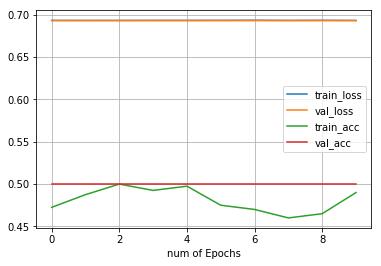

In [28]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('num of Epochs')
plt.grid(True)
plt.legend(['train_loss','val_loss','train_acc', 'val_acc'])

plt.show()